In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Tắt cảnh báo
warnings.filterwarnings('ignore')

# Cài đặt style cho matplotlib
plt.style.use('default')
sns.set_palette("husl")

# Cài đặt font cho tiếng Việt
plt.rcParams['font.family'] = ['DejaVu Sans']

print("✅ Đã import các thư viện thành công!")

✅ Đã import các thư viện thành công!


In [2]:
# Load file Excel
file_path = '4_stations_31_7.xlsx'
print(f"📁 Đang load file: {file_path}")

# Load dữ liệu
df = pd.read_excel(file_path)
print(f"📈 Dữ liệu gốc: {df.shape[0]} hàng, {df.shape[1]} cột")
print(f"📋 Tên các cột: {list(df.columns)}")

# Kiểm tra dữ liệu thiếu
print("\n🔍 KIỂM TRA DỮ LIỆU THIẾU:")
missing_data = df.isnull().sum()
missing_cols = missing_data[missing_data > 0]

if len(missing_cols) > 0:
    print("Các cột có dữ liệu thiếu:")
    for col, count in missing_cols.items():
        percentage = (count / len(df)) * 100
        print(f"  - {col}: {count} ({percentage:.1f}%)")
else:
    print("✅ Không có dữ liệu thiếu")

# Loại bỏ các cột có quá nhiều dữ liệu thiếu (>50%)
threshold = len(df) * 0.5
columns_to_drop = missing_data[missing_data > threshold].index
if len(columns_to_drop) > 0:
    print(f"\n🗑️  Loại bỏ các cột có quá nhiều dữ liệu thiếu: {list(columns_to_drop)}")
    df = df.drop(columns=columns_to_drop)

# Loại bỏ các hàng có dữ liệu thiếu
df_clean = df.dropna()
print(f"\n🧹 Số hàng sau khi loại bỏ dữ liệu thiếu: {len(df_clean)} (trước đó: {len(df)})")

📁 Đang load file: 4_stations_31_7.xlsx
📈 Dữ liệu gốc: 12418 hàng, 19 cột
📋 Tên các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Year', 'Unnamed: 9', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Unnamed: 17', '>=1.6']

🔍 KIỂM TRA DỮ LIỆU THIẾU:
Các cột có dữ liệu thiếu:
  - Unnamed: 9: 12237 (98.5%)
  - Decustering ID: 12237 (98.5%)
  - Times.1: 12237 (98.5%)
  - water level.1: 12237 (98.5%)
  - rainfall.1: 12237 (98.5%)
  - LSL.1: 12237 (98.5%)
  - Built-up.1: 12237 (98.5%)
  - Ups_discharge (Trian).1: 12237 (98.5%)
  - Unnamed: 17: 12418 (100.0%)
  - >=1.6: 12237 (98.5%)

🗑️  Loại bỏ các cột có quá nhiều dữ liệu thiếu: ['Unnamed: 9', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Unnamed: 17', '>=1.6']

🧹 Số hàng sau khi loại bỏ dữ liệu thiếu: 12418 (trước đó: 12418)


In [3]:
# Chọn chỉ các cột số để tính correlation
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
print(f"🔢 CÁC CỘT SỐ TRONG DATASET:")
for i, col in enumerate(numeric_columns, 1):
    print(f"  {i:2d}. {col}")
print(f"\n📊 Số cột số: {len(numeric_columns)}")

# Tạo dataframe chỉ chứa các cột số
df_numeric = df_clean[numeric_columns]

# Loại bỏ ID.1 và ID (trùng lặp)
if 'ID.1' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['ID.1'])
    print("🗑️  Đã loại bỏ cột ID.1 (trùng lặp)")
if 'ID' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['ID'])
    print("🗑️  Đã loại bỏ cột ID (trùng lặp)")

print(f"\n✅ Dữ liệu sau khi làm sạch: {df_numeric.shape[0]} hàng, {df_numeric.shape[1]} cột")
print(f"🔢 Các biến cuối cùng: {list(df_numeric.columns)}")

# Hiển thị thống kê mô tả
print("\n📈 THỐNG KÊ MÔ TẢ:")
print(df_numeric.describe().round(3))

🔢 CÁC CỘT SỐ TRONG DATASET:
   1. ID
   2. ID.1
   3. water level
   4. rainfall
   5. LSL
   6. Built-up
   7. Ups_discharge (Trian)
   8. Year

📊 Số cột số: 8
🗑️  Đã loại bỏ cột ID.1 (trùng lặp)
🗑️  Đã loại bỏ cột ID (trùng lặp)

✅ Dữ liệu sau khi làm sạch: 12418 hàng, 6 cột
🔢 Các biến cuối cùng: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Year']

📈 THỐNG KÊ MÔ TẢ:
       water level   rainfall        LSL   Built-up  Ups_discharge (Trian)  \
count    12418.000  12418.000  12418.000  12418.000              12418.000   
mean         1.129      4.906      0.740    123.917                524.177   
std          0.288     12.143      0.238     66.684                542.889   
min          0.180      0.000      0.000     42.040                  0.000   
25%          0.930      0.000      0.570     66.054                102.425   
50%          1.160      0.000      0.740    106.799                293.000   
75%          1.330      3.500      0.910    172.540    

In [5]:
# Các biến chính để phân tích
main_variables = ['water level', 'rainfall', 'LSL', 'Ups_discharge (Trian)']
print("⏰ PHÂN TÍCH LAGGED TIME CORRELATION")
print("=" * 50)

# Tạo các lag từ 1 đến 30 ngày
max_lag = 30
lag_results = {}

print(f"🔍 Phân tích lag từ 1 đến {max_lag} ngày...")

for var1 in main_variables:
    if var1 not in df_numeric.columns:
        continue
        
    lag_results[var1] = {}
    
    for var2 in main_variables:
        if var2 not in df_numeric.columns or var1 == var2:
            continue
            
        lag_results[var1][var2] = {}
        
        for lag in range(1, max_lag + 1):
            # Tạo lag cho var1
            lagged_var1 = df_numeric[var1].shift(lag)
            
            # Tính correlation với var2
            correlation = df_numeric[var2].corr(lagged_var1)
            
            if not np.isnan(correlation):
                lag_results[var1][var2][lag] = correlation

print("✅ Đã tính xong lag correlation cho tất cả cặp biến!")

⏰ PHÂN TÍCH LAGGED TIME CORRELATION
🔍 Phân tích lag từ 1 đến 30 ngày...
✅ Đã tính xong lag correlation cho tất cả cặp biến!


In [6]:
# Tìm lag tốt nhất cho từng cặp biến
print("\n🏆 LAG TỐT NHẤT CHO TỪNG CẶP BIẾN:")
print("-" * 50)

best_lags = {}

for var1 in lag_results:
    for var2 in lag_results[var1]:
        correlations = lag_results[var1][var2]
        if correlations:
            # Tìm lag có correlation cao nhất
            best_lag = max(correlations.keys(), key=lambda x: abs(correlations[x]))
            best_corr = correlations[best_lag]
            
            best_lags[(var1, var2)] = {
                'lag': best_lag,
                'correlation': best_corr
            }
            
            print(f"📊 {var1} → {var2}:")
            print(f"   Lag tốt nhất: {best_lag} ngày")
            print(f"   Correlation: {best_corr:.3f}")
            print()

# Tìm lag có correlation cao nhất
if best_lags:
    best_overall = max(best_lags.items(), key=lambda x: abs(x[1]['correlation']))
    print(f"🏆 LAG TỐT NHẤT TỔNG THỂ:")
    print(f"   {best_overall[0][0]} → {best_overall[0][1]}: Lag {best_overall[1]['lag']} ngày (corr = {best_overall[1]['correlation']:.3f})")


🏆 LAG TỐT NHẤT CHO TỪNG CẶP BIẾN:
--------------------------------------------------
📊 water level → rainfall:
   Lag tốt nhất: 30 ngày
   Correlation: -0.036

📊 water level → LSL:
   Lag tốt nhất: 29 ngày
   Correlation: 0.590

📊 water level → Ups_discharge (Trian):
   Lag tốt nhất: 1 ngày
   Correlation: 0.246

📊 rainfall → water level:
   Lag tốt nhất: 27 ngày
   Correlation: 0.067

📊 rainfall → LSL:
   Lag tốt nhất: 1 ngày
   Correlation: -0.080

📊 rainfall → Ups_discharge (Trian):
   Lag tốt nhất: 2 ngày
   Correlation: 0.283

📊 LSL → water level:
   Lag tốt nhất: 1 ngày
   Correlation: 0.571

📊 LSL → rainfall:
   Lag tốt nhất: 30 ngày
   Correlation: -0.151

📊 LSL → Ups_discharge (Trian):
   Lag tốt nhất: 30 ngày
   Correlation: -0.327

📊 Ups_discharge (Trian) → water level:
   Lag tốt nhất: 30 ngày
   Correlation: 0.295

📊 Ups_discharge (Trian) → rainfall:
   Lag tốt nhất: 1 ngày
   Correlation: 0.224

📊 Ups_discharge (Trian) → LSL:
   Lag tốt nhất: 30 ngày
   Correlation: 0.16


🎨 VẼ BIỂU ĐỒ LAG CORRELATION...
💾 Đã lưu lagged time analysis vào 'lagged_time_analysis.png'


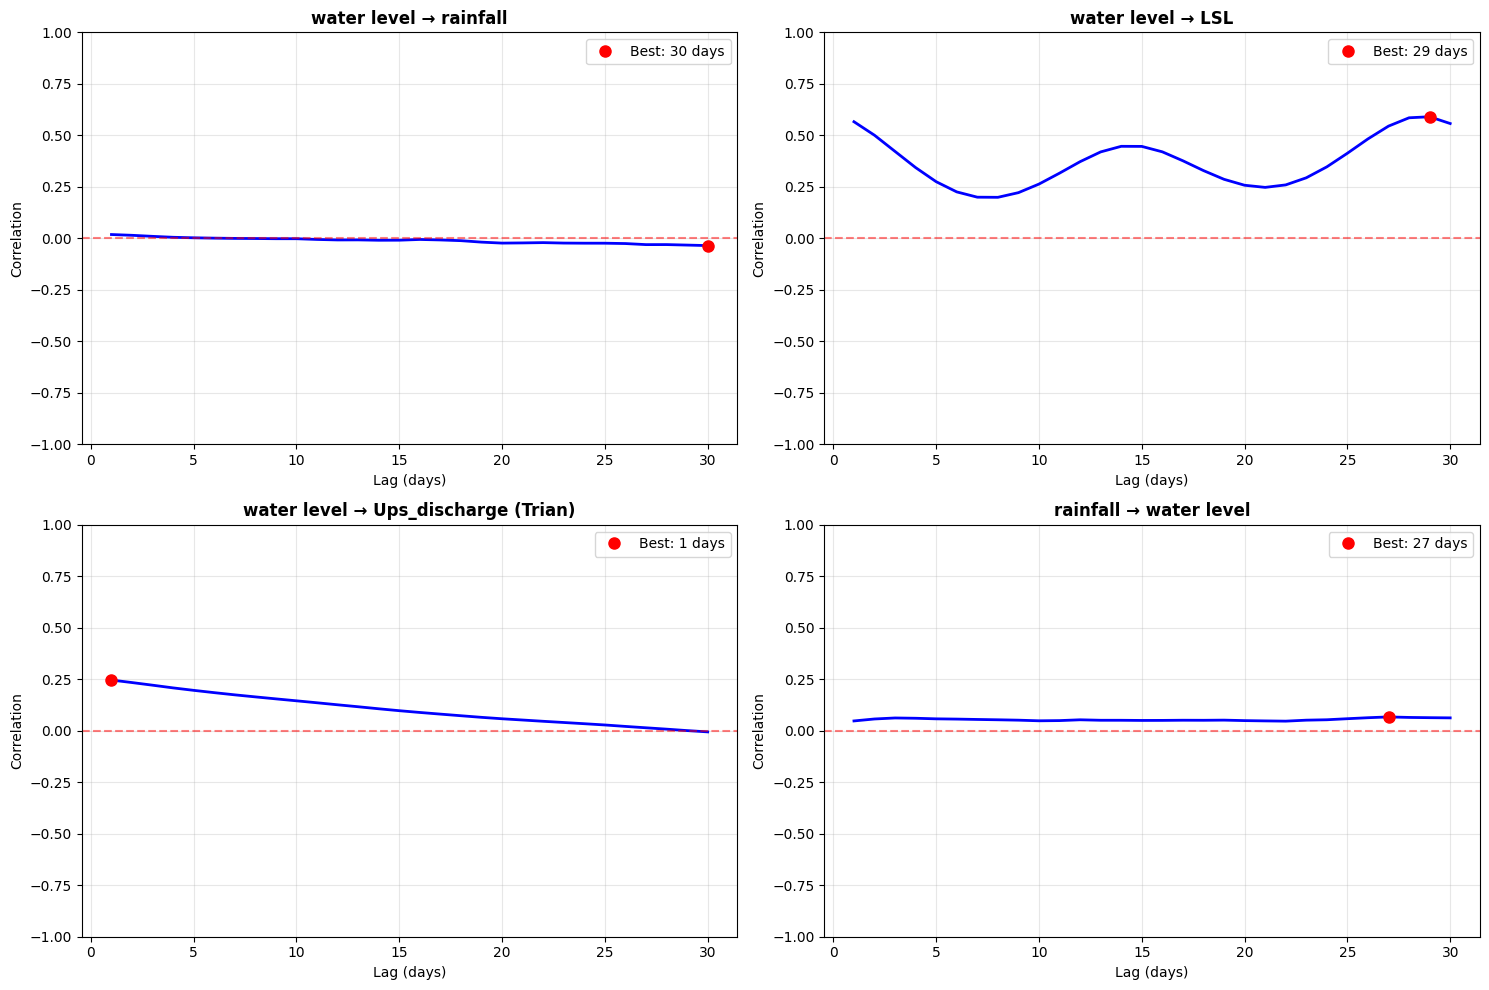

In [7]:
# Vẽ biểu đồ lag correlation
print("\n🎨 VẼ BIỂU ĐỒ LAG CORRELATION...")

# Tạo subplot cho từng cặp biến
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

plot_idx = 0
for var1 in main_variables:
    for var2 in main_variables:
        if var1 != var2 and (var1, var2) in best_lags:
            if plot_idx < 4:
                # Lấy tất cả correlation cho cặp này
                correlations = lag_results[var1][var2]
                lags = list(correlations.keys())
                corr_values = list(correlations.values())
                
                axes[plot_idx].plot(lags, corr_values, 'b-', linewidth=2)
                axes[plot_idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)
                axes[plot_idx].set_title(f'{var1} → {var2}', fontsize=12, fontweight='bold')
                axes[plot_idx].set_xlabel('Lag (days)')
                axes[plot_idx].set_ylabel('Correlation')
                axes[plot_idx].grid(True, alpha=0.3)
                axes[plot_idx].set_ylim(-1, 1)
                
                # Đánh dấu lag tốt nhất
                best_lag = best_lags[(var1, var2)]['lag']
                best_corr = best_lags[(var1, var2)]['correlation']
                axes[plot_idx].plot(best_lag, best_corr, 'ro', markersize=8, label=f'Best: {best_lag} days')
                axes[plot_idx].legend()
                
                plot_idx += 1

plt.tight_layout()
plt.savefig('lagged_time_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Đã lưu lagged time analysis vào 'lagged_time_analysis.png'")
plt.show()

In [8]:
# Phân tích tương quan giữa các thống kê (min, max, mean)
print("\n📈 PHÂN TÍCH STATISTICAL CORRELATION")
print("=" * 50)

# Các biến chính
main_variables = ['water level', 'rainfall', 'LSL', 'Ups_discharge (Trian)']

# Tính các thống kê cho từng biến
stats_data = {}

for var in main_variables:
    if var not in df_numeric.columns:
        continue
        
    stats_data[var] = {
        'min': df_numeric[var].min(),
        'max': df_numeric[var].max(),
        'mean': df_numeric[var].mean(),
        'std': df_numeric[var].std(),
        'median': df_numeric[var].median(),
        'q25': df_numeric[var].quantile(0.25),
        'q75': df_numeric[var].quantile(0.75)
    }

print("📊 THỐNG KÊ CỦA CÁC BIẾN:")
print("-" * 50)

stats_df = pd.DataFrame(stats_data).T
print(stats_df.round(3))


📈 PHÂN TÍCH STATISTICAL CORRELATION
📊 THỐNG KÊ CỦA CÁC BIẾN:
--------------------------------------------------
                        min      max     mean      std  median      q25  \
water level            0.18     2.19    1.129    0.288    1.16    0.930   
rainfall               0.00   194.50    4.906   12.143    0.00    0.000   
LSL                    0.00     1.48    0.740    0.238    0.74    0.570   
Ups_discharge (Trian)  0.00  3910.00  524.177  542.889  293.00  102.425   

                           q75  
water level              1.330  
rainfall                 3.500  
LSL                      0.910  
Ups_discharge (Trian)  827.075  


In [9]:
# Tạo dataframe với tất cả thống kê
all_stats = []
stat_types = ['min', 'max', 'mean', 'std', 'median', 'q25', 'q75']

for var in main_variables:
    if var in stats_data:
        for stat_type in stat_types:
            all_stats.append({
                'variable': var,
                'stat_type': stat_type,
                'value': stats_data[var][stat_type]
            })

stats_wide = pd.DataFrame(all_stats)
stats_pivot = stats_wide.pivot(index='variable', columns='stat_type', values='value')

# Tính correlation
stats_correlation = stats_pivot.corr()

print("\n🔗 TƯƠNG QUAN GIỮA CÁC LOẠI THỐNG KÊ:")
print("-" * 50)
print("Ma trận tương quan giữa các loại thống kê:")
print(stats_correlation.round(3))

# Tìm thống kê có tương quan cao nhất
high_corr_stats = []
for i in range(len(stats_correlation.columns)):
    for j in range(i+1, len(stats_correlation.columns)):
        corr_value = stats_correlation.iloc[i, j]
        if not np.isnan(corr_value) and abs(corr_value) > 0.5:
            high_corr_stats.append({
                'stat1': stats_correlation.columns[i],
                'stat2': stats_correlation.columns[j],
                'correlation': corr_value
            })

if high_corr_stats:
    high_corr_stats.sort(key=lambda x: abs(x['correlation']), reverse=True)
    print(f"\n🏆 THỐNG KÊ CÓ TƯƠNG QUAN CAO NHẤT:")
    for stat_pair in high_corr_stats[:3]:
        print(f"• {stat_pair['stat1']} vs {stat_pair['stat2']}: {stat_pair['correlation']:.3f}")


🔗 TƯƠNG QUAN GIỮA CÁC LOẠI THỐNG KÊ:
--------------------------------------------------
Ma trận tương quan giữa các loại thống kê:
stat_type    max   mean  median    min    q25    q75    std
stat_type                                                  
max        1.000  0.999   0.999 -0.355  0.999  0.999  1.000
mean       0.999  1.000   1.000 -0.336  1.000  1.000  1.000
median     0.999  1.000   1.000 -0.331  1.000  1.000  1.000
min       -0.355 -0.336  -0.331  1.000 -0.328 -0.334 -0.343
q25        0.999  1.000   1.000 -0.328  1.000  1.000  1.000
q75        0.999  1.000   1.000 -0.334  1.000  1.000  1.000
std        1.000  1.000   1.000 -0.343  1.000  1.000  1.000

🏆 THỐNG KÊ CÓ TƯƠNG QUAN CAO NHẤT:
• median vs q25: 1.000
• mean vs q75: 1.000
• median vs q75: 1.000


💾 Đã lưu statistical correlation analysis vào 'statistical_correlation_analysis.png'


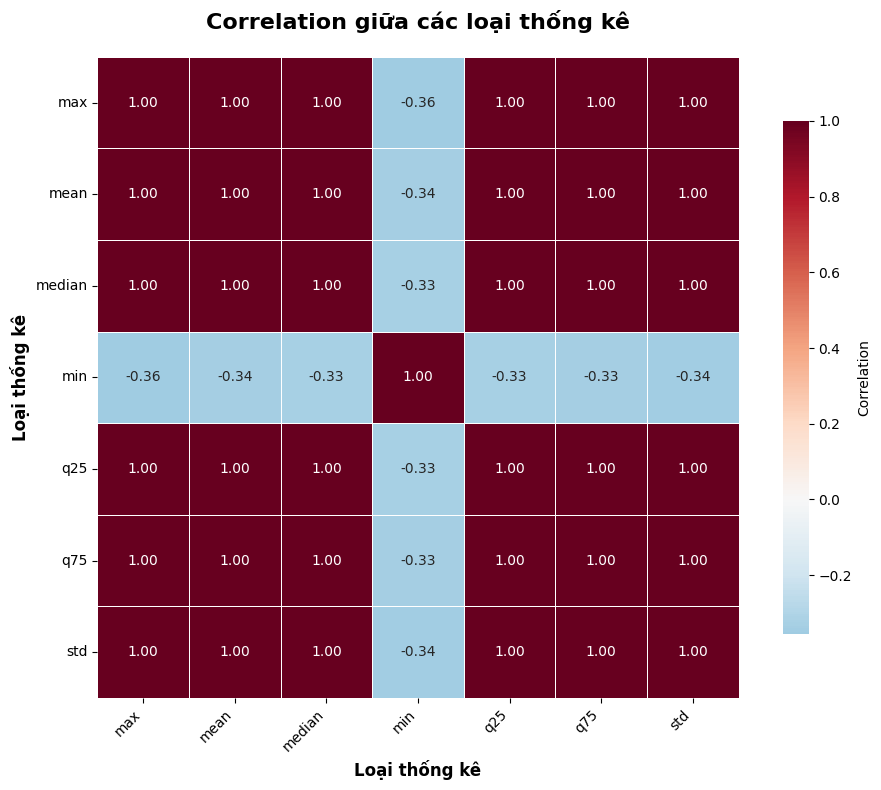

In [10]:
# Vẽ heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(stats_correlation, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            square=True, 
            fmt='.2f', 
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'})

plt.title('Correlation giữa các loại thống kê', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Loại thống kê', fontsize=12, fontweight='bold')
plt.ylabel('Loại thống kê', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('statistical_correlation_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Đã lưu statistical correlation analysis vào 'statistical_correlation_analysis.png'")
plt.show()

In [12]:
# Phân tích chi tiết từng loại thống kê
print("\n🔍 PHÂN TÍCH CHI TIẾT TỪNG LOẠI THỐNG KÊ:")
print("-" * 50)

for stat_type in stat_types:
    print(f"\n📊 {stat_type.upper()}:")
    
    # Hiển thị giá trị thống kê cho từng biến
    stat_values = {}
    for var in main_variables:
        if var in stats_data:
            stat_values[var] = stats_data[var][stat_type]
    
    if len(stat_values) > 0:
        print("Giá trị thống kê của các biến:")
        for var, value in stat_values.items():
            print(f"  • {var}: {value:.3f}")
        
        # Tìm biến có giá trị cao nhất và thấp nhất
        if len(stat_values) > 1:
            max_var = max(stat_values.items(), key=lambda x: x[1])
            min_var = min(stat_values.items(), key=lambda x: x[1])
            
            print(f"\n🏆 Biến có {stat_type} cao nhất: {max_var[0]} = {max_var[1]:.3f}")
            print(f"📉 Biến có {stat_type} thấp nhất: {min_var[0]} = {min_var[1]:.3f}")
            
            # Tính tỷ lệ giữa max và min
            if min_var[1] != 0:
                ratio = max_var[1] / min_var[1]
                print(f"📊 Tỷ lệ max/min: {ratio:.2f}")
            
            # Phân tích phân phối
            values_list = list(stat_values.values())
            if len(values_list) > 1:
                range_val = max(values_list) - min(values_list)
                mean_val = np.mean(values_list)
                print(f"📈 Phạm vi: {range_val:.3f}")
                print(f"📊 Giá trị trung bình: {mean_val:.3f}")
        
        print("-" * 30)


🔍 PHÂN TÍCH CHI TIẾT TỪNG LOẠI THỐNG KÊ:
--------------------------------------------------

📊 MIN:
Giá trị thống kê của các biến:
  • water level: 0.180
  • rainfall: 0.000
  • LSL: 0.000
  • Ups_discharge (Trian): 0.000

🏆 Biến có min cao nhất: water level = 0.180
📉 Biến có min thấp nhất: rainfall = 0.000
📈 Phạm vi: 0.180
📊 Giá trị trung bình: 0.045
------------------------------

📊 MAX:
Giá trị thống kê của các biến:
  • water level: 2.190
  • rainfall: 194.500
  • LSL: 1.480
  • Ups_discharge (Trian): 3910.000

🏆 Biến có max cao nhất: Ups_discharge (Trian) = 3910.000
📉 Biến có max thấp nhất: LSL = 1.480
📊 Tỷ lệ max/min: 2641.89
📈 Phạm vi: 3908.520
📊 Giá trị trung bình: 1027.043
------------------------------

📊 MEAN:
Giá trị thống kê của các biến:
  • water level: 1.129
  • rainfall: 4.906
  • LSL: 0.740
  • Ups_discharge (Trian): 524.177

🏆 Biến có mean cao nhất: Ups_discharge (Trian) = 524.177
📉 Biến có mean thấp nhất: LSL = 0.740
📊 Tỷ lệ max/min: 707.99
📈 Phạm vi: 523.437
📊 Giá


📊 PHÂN TÍCH ROLLING CORRELATION

📈 Rolling correlation với window = 7 ngày:
💾 Đã lưu rolling correlation (window=7) vào 'rolling_correlation_window_7.png'


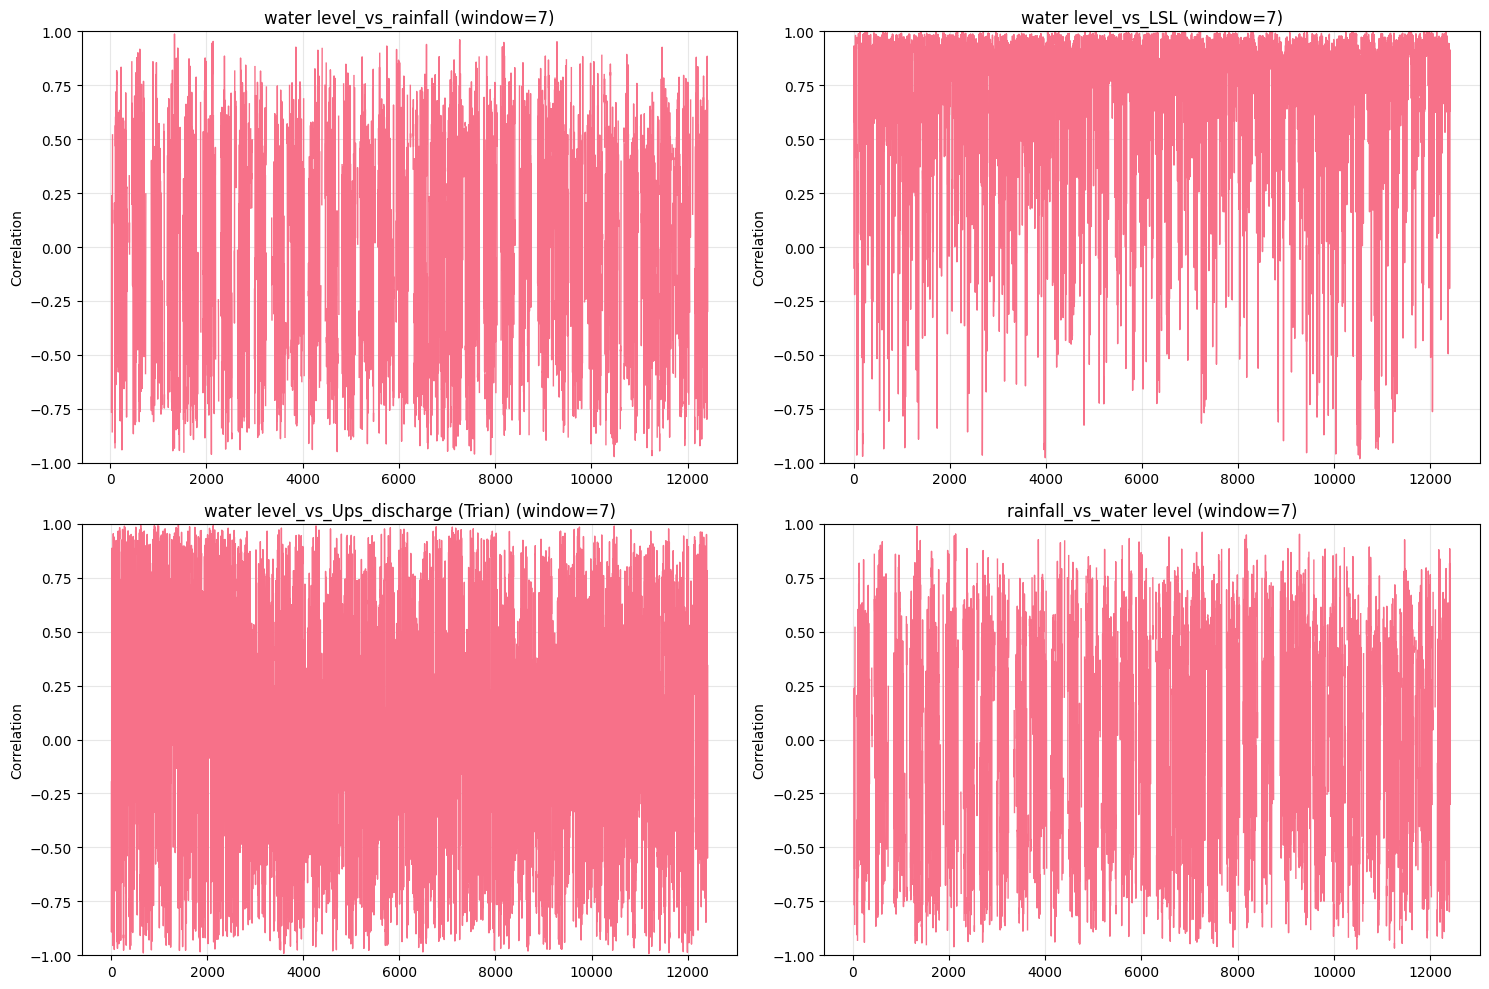


📈 Rolling correlation với window = 30 ngày:
💾 Đã lưu rolling correlation (window=30) vào 'rolling_correlation_window_30.png'


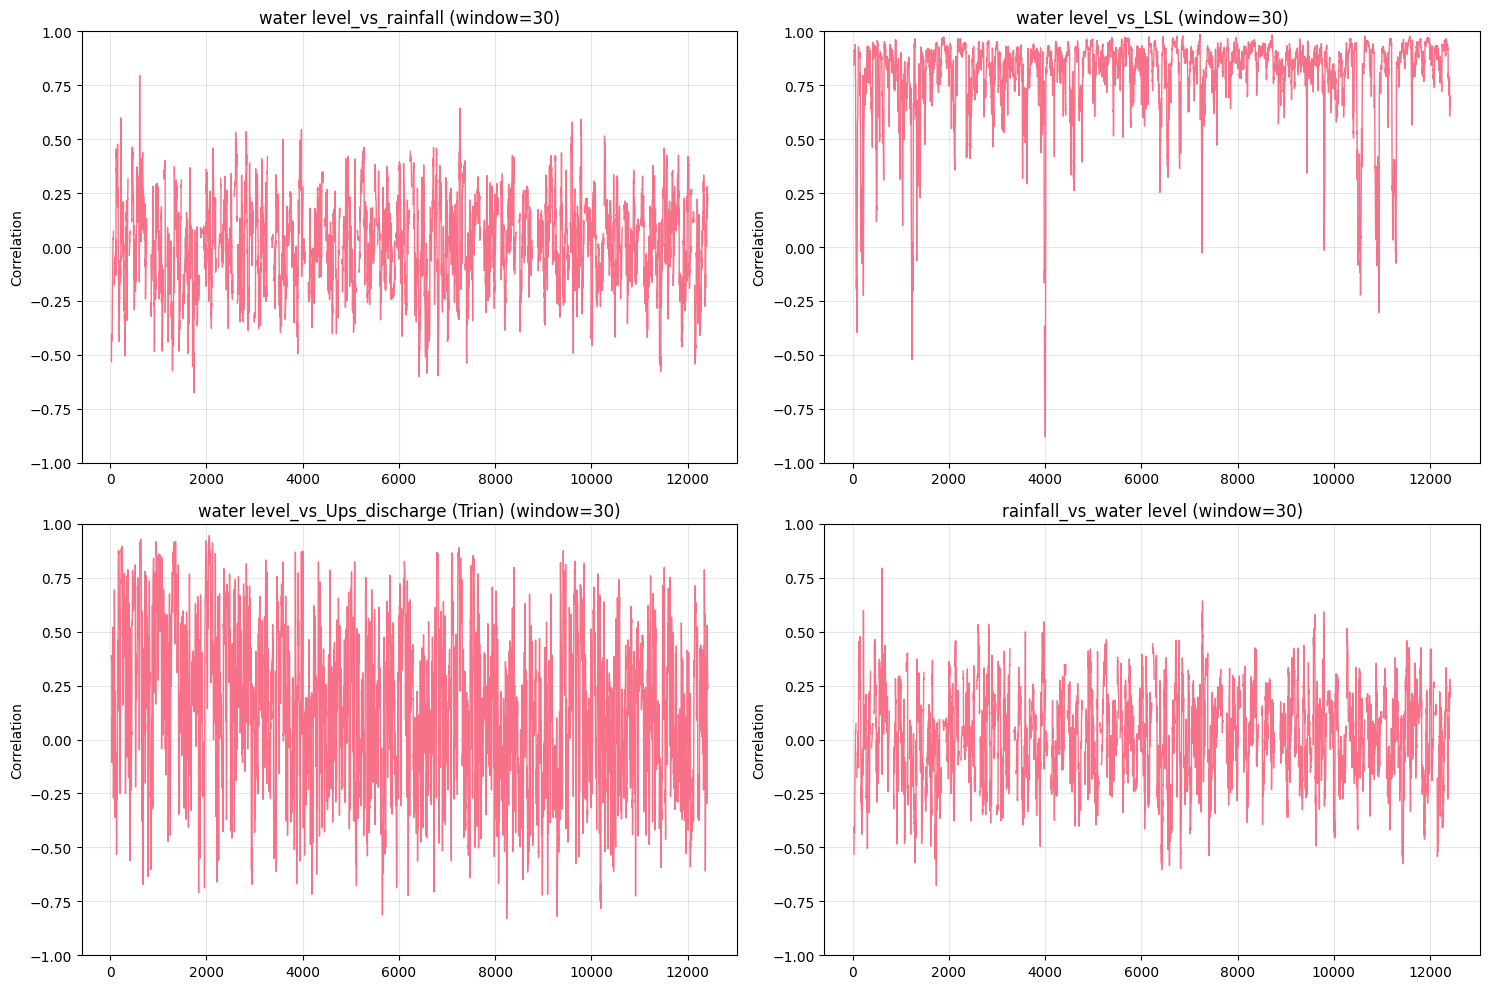


📈 Rolling correlation với window = 90 ngày:
💾 Đã lưu rolling correlation (window=90) vào 'rolling_correlation_window_90.png'


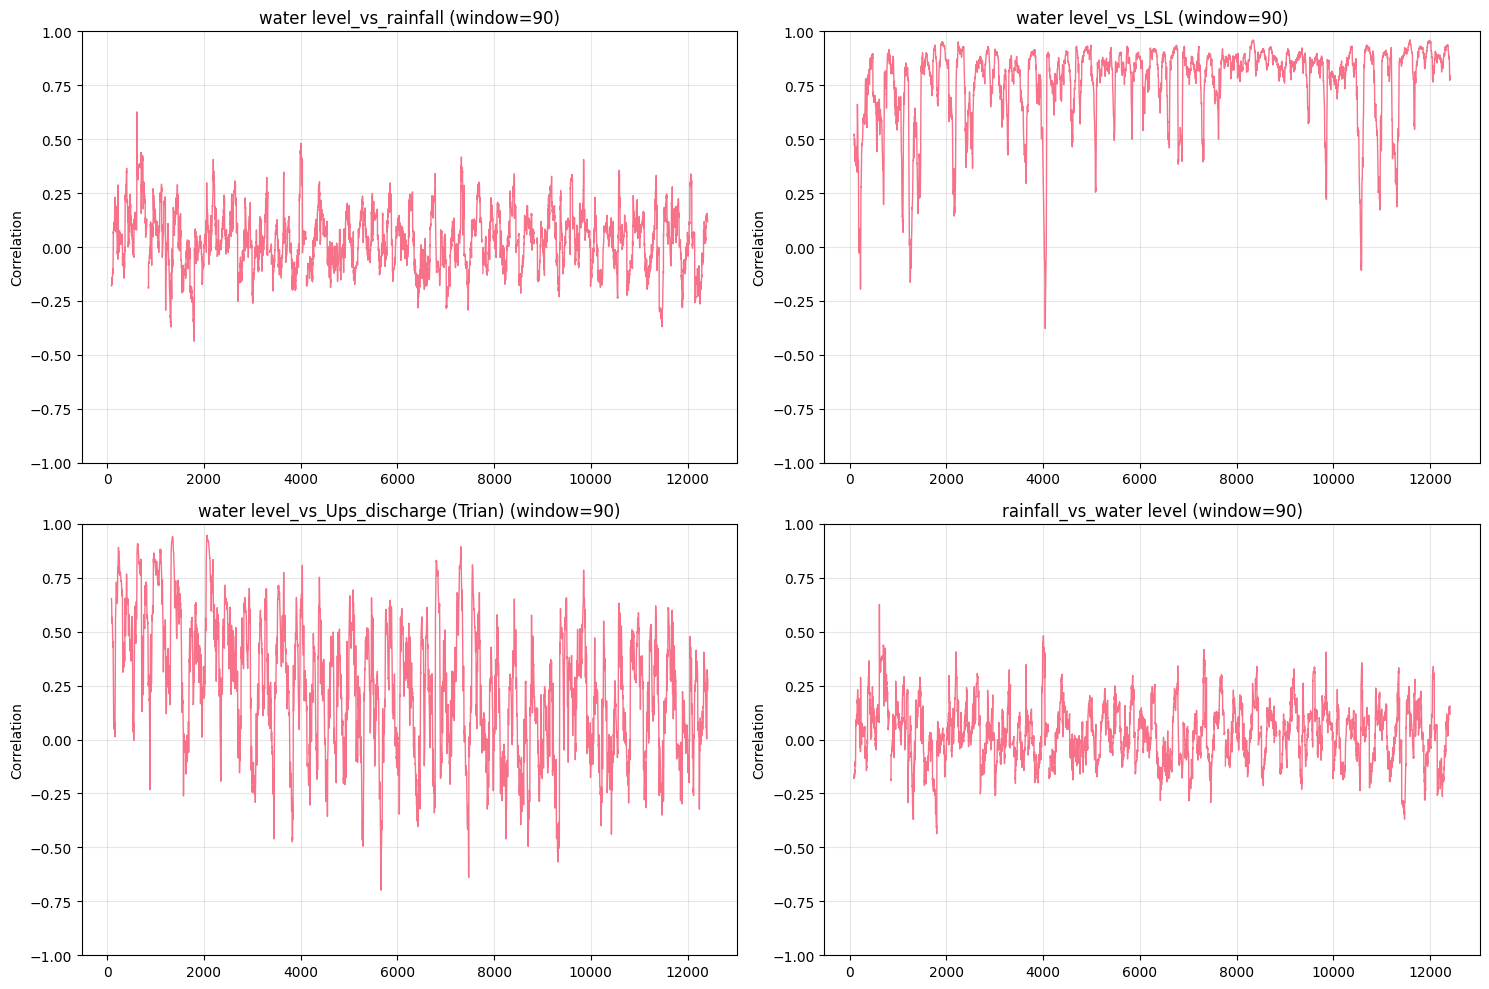

In [13]:
# Phân tích tương quan trượt theo thời gian
print("\n📊 PHÂN TÍCH ROLLING CORRELATION")
print("=" * 50)

# Các biến chính
main_variables = ['water level', 'rainfall', 'LSL', 'Ups_discharge (Trian)']

# Tính rolling correlation với window = 30 ngày
window_sizes = [7, 30, 90]

for window in window_sizes:
    print(f"\n📈 Rolling correlation với window = {window} ngày:")
    
    # Tính rolling correlation cho từng cặp biến
    rolling_corrs = {}
    
    for var1 in main_variables:
        for var2 in main_variables:
            if var1 != var2 and var1 in df_numeric.columns and var2 in df_numeric.columns:
                rolling_corr = df_numeric[var1].rolling(window=window).corr(df_numeric[var2])
                rolling_corrs[f"{var1}_vs_{var2}"] = rolling_corr
    
    # Vẽ biểu đồ rolling correlation
    if rolling_corrs:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, (pair_name, rolling_corr) in enumerate(rolling_corrs.items()):
            if i < 4:  # Chỉ vẽ 4 cặp đầu tiên
                axes[i].plot(rolling_corr.index, rolling_corr.values, linewidth=1)
                axes[i].set_title(f'{pair_name} (window={window})', fontsize=12)
                axes[i].set_ylabel('Correlation')
                axes[i].grid(True, alpha=0.3)
                axes[i].set_ylim(-1, 1)
        
        plt.tight_layout()
        plt.savefig(f'rolling_correlation_window_{window}.png', dpi=300, bbox_inches='tight')
        print(f"💾 Đã lưu rolling correlation (window={window}) vào 'rolling_correlation_window_{window}.png'")
        plt.show()

In [14]:
# Tóm tắt kết quả
print("\n📋 TÓM TẮT KẾT QUẢ PHÂN TÍCH NÂNG CAO")
print("=" * 60)

print("\n🏆 LAG TỐT NHẤT:")
print("-" * 30)
for (var1, var2), info in best_lags.items():
    print(f"• {var1} → {var2}: Lag {info['lag']} ngày (corr = {info['correlation']:.3f})")

print("\n📊 THỐNG KÊ TỐT NHẤT:")
print("-" * 30)
# Tìm thống kê có tương quan cao nhất
high_corr_stats = []
for i in range(len(stats_correlation.columns)):
    for j in range(i+1, len(stats_correlation.columns)):
        corr_value = stats_correlation.iloc[i, j]
        if not np.isnan(corr_value) and abs(corr_value) > 0.5:
            high_corr_stats.append({
                'stat1': stats_correlation.columns[i],
                'stat2': stats_correlation.columns[j],
                'correlation': corr_value
            })

if high_corr_stats:
    high_corr_stats.sort(key=lambda x: abs(x['correlation']), reverse=True)
    for stat_pair in high_corr_stats[:3]:
        print(f"• {stat_pair['stat1']} vs {stat_pair['stat2']}: {stat_pair['correlation']:.3f}")

print("\n📁 FILES ĐÃ TẠO:")
print("-" * 30)
print("• lagged_time_analysis.png")
print("• statistical_correlation_analysis.png")
print("• rolling_correlation_window_7.png")
print("• rolling_correlation_window_30.png")
print("• rolling_correlation_window_90.png")

print("\n✅ HOÀN THÀNH PHÂN TÍCH NÂNG CAO!")


📋 TÓM TẮT KẾT QUẢ PHÂN TÍCH NÂNG CAO

🏆 LAG TỐT NHẤT:
------------------------------
• water level → rainfall: Lag 30 ngày (corr = -0.036)
• water level → LSL: Lag 29 ngày (corr = 0.590)
• water level → Ups_discharge (Trian): Lag 1 ngày (corr = 0.246)
• rainfall → water level: Lag 27 ngày (corr = 0.067)
• rainfall → LSL: Lag 1 ngày (corr = -0.080)
• rainfall → Ups_discharge (Trian): Lag 2 ngày (corr = 0.283)
• LSL → water level: Lag 1 ngày (corr = 0.571)
• LSL → rainfall: Lag 30 ngày (corr = -0.151)
• LSL → Ups_discharge (Trian): Lag 30 ngày (corr = -0.327)
• Ups_discharge (Trian) → water level: Lag 30 ngày (corr = 0.295)
• Ups_discharge (Trian) → rainfall: Lag 1 ngày (corr = 0.224)
• Ups_discharge (Trian) → LSL: Lag 30 ngày (corr = 0.161)

📊 THỐNG KÊ TỐT NHẤT:
------------------------------
• median vs q25: 1.000
• mean vs q75: 1.000
• median vs q75: 1.000

📁 FILES ĐÃ TẠO:
------------------------------
• lagged_time_analysis.png
• statistical_correlation_analysis.png
• rolling_corre